# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [ ]:
import tensorflow as tf
from scipy.io import loadmat
import numpy as np
import pandas as pd

![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [2]:
# Run this cell to load the dataset

train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [3]:
from sklearn.preprocessing import OneHotEncoder

x_train = np.transpose(train['X'], (3,0,1,2)) / 255.
x_test = np.transpose(test['X'], (3,0,1,2)) / 255.
 
encoder = OneHotEncoder(sparse=False)

y_train = encoder.fit_transform(train['y'] % 10)
y_test = encoder.fit_transform(test['y'] % 10)

x_train.shape, x_test.shape

((73257, 32, 32, 3), (26032, 32, 32, 3))

In [4]:
import random
import matplotlib.pyplot as plt

def random_imgs(x, y):
    num_samples = x.shape[0] 
    indexs = random.sample(range(0, num_samples + 1), 15)
    fig, axs = plt.subplots(nrows = 3, ncols = 5, figsize=(10,10))

    for idx, ax in zip(indexs, axs.flatten()):
        #usual case
        if(x[idx].shape == (32,32,3)):
            ax.imshow(x[idx])
        else: #graymap
            ax.imshow(x[idx,...,0],cmap='gray')
        ax.set_xlabel("label: " + str(np.argmax(y[idx])))

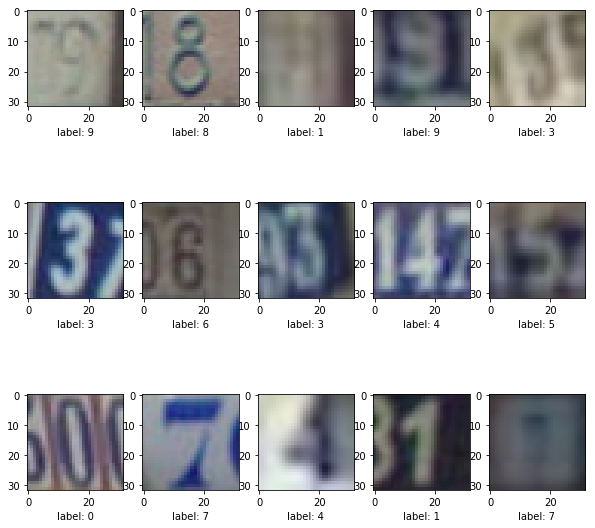

In [5]:
random_imgs(x_train, y_train)

In [6]:
def rgb2gray(img):
        return np.dot(img, [0.2989, 0.5870, 0.1140])[...,np.newaxis]
    
x_train_gray = rgb2gray(x_train).astype(np.float32)
x_test_gray = rgb2gray(x_test).astype(np.float32)

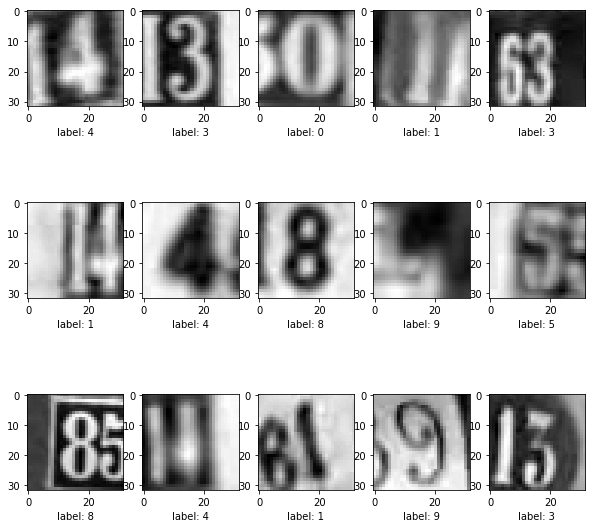

In [7]:
random_imgs(x_train_gray, y_train)

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def get_mlp_model(input_shape):
    
    model = Sequential([
        Flatten(name='flatten_1', input_shape = input_shape),
        Dense(128, activation = 'relu',name='dense_1'),
        Dense(128, activation='relu',name='dense_2'),
        Dense(128, activation='relu', name='dense_3'),
        Dense(128, activation='relu', name='dense_4'),
        Dense(64, activation='relu', name='dense_5'),
        Dense(10, activation='softmax', name='output')
    ])

    model.compile(optimizer = 'sgd',
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy']
    )
    
    return model

In [9]:
def get_test_results(model, x_test_gray, y_test):
    test_loss, test_acc = model.evaluate(x=x_test_gray, 
                                         y=y_test, 
                                         verbose=0)
    print(f"Test accuracy is {test_acc}")
    print(f"Test loss is {test_loss}")

In [10]:
model_mlp = get_mlp_model(x_train_gray[0].shape)
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
output (Dense)               (None, 10)                6

In [11]:
checkpoint_path_best_mlp = "checkpoints_best_only_mlp/checkpoint"
checkpoint_mlp = ModelCheckpoint(filepath=checkpoint_path_best_mlp,
                                save_weights_only=True,
                                save_best_only=True,
                                save_freq='epoch',
                                monitor = 'val_accuracy',
                                verbose = 1)

early_stopping = EarlyStopping(monitor = 'val_accuracy',
                                  patience=3, verbose=1)

In [12]:
shape = x_train_gray[0].shape
model = get_mlp_model(shape)

In [13]:
callbacks = [checkpoint_mlp, early_stopping]
history_mlp = model_mlp.fit(x_train_gray, y_train, epochs=30, 
                            batch_size=None, validation_split=0.15, 
                            callbacks=callbacks, verbose = 1) 

Train on 62268 samples, validate on 10989 samples
Epoch 1/30
62048/62268 [============================>.] - ETA: 0s - loss: 2.2053 - accuracy: 0.1997
Epoch 00001: val_accuracy improved from -inf to 0.26772, saving model to checkpoints_best_only_mlp/checkpoint
62268/62268 [==============================] - 23s 366us/sample - loss: 2.2048 - accuracy: 0.2001 - val_loss: 2.0946 - val_accuracy: 0.2677
Epoch 2/30
62208/62268 [============================>.] - ETA: 0s - loss: 1.8248 - accuracy: 0.3657
Epoch 00002: val_accuracy improved from 0.26772 to 0.46483, saving model to checkpoints_best_only_mlp/checkpoint
62268/62268 [==============================] - 21s 343us/sample - loss: 1.8245 - accuracy: 0.3658 - val_loss: 1.5648 - val_accuracy: 0.4648
Epoch 3/30
62080/62268 [============================>.] - ETA: 0s - loss: 1.4853 - accuracy: 0.5012
Epoch 00003: val_accuracy improved from 0.46483 to 0.57330, saving model to checkpoints_best_only_mlp/checkpoint
62268/62268 [=====================

In [14]:
get_test_results(model_mlp, x_test_gray, y_test)

Test accuracy is 0.7609865069389343
Test loss is 0.7949237119917058


In [15]:
def plot_models(history):
    
    
    fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize=(10,10))
    axs[0].plot(history['val_loss'], label = 'validation loss', color = 'blue')
    axs[0].plot(history['loss'], label = 'training loss', color = 'red')
    axs[0].set_ylabel('val loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend()
    axs[1].plot(history['val_accuracy'], label = 'validation accuracy',color = 'blue')
    axs[1].plot(history['accuracy'], label = 'training accuracy',color = 'red')
    axs[1].set_ylabel('val accuracy')
    axs[1].legend()
    axs[1].set_xlabel('epoch')

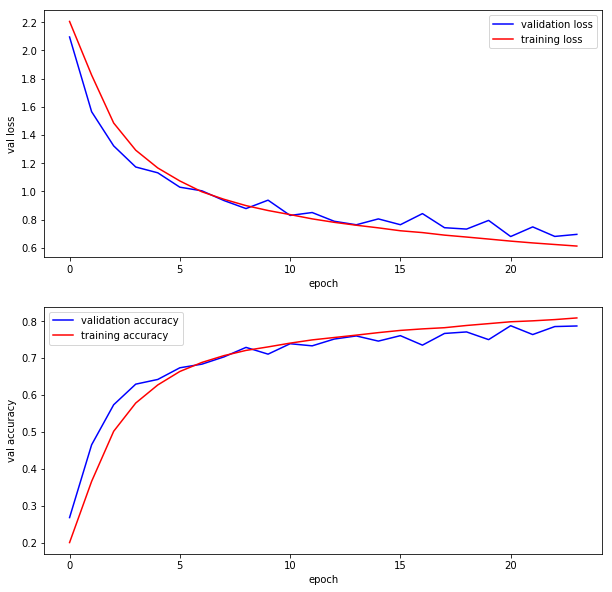

In [16]:
plot_models(history_mlp.history)

In [17]:
! ls -lh checkpoints_best_only_mlp

total 752K
-rw-r--r-- 1 jovyan users   77 Mar  6 20:04 checkpoint
-rw-r--r-- 1 jovyan users 743K Mar  6 20:04 checkpoint.data-00000-of-00001
-rw-r--r-- 1 jovyan users 1.1K Mar  6 20:04 checkpoint.index


## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [18]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout

def get_cnn_model(input_shape):
    
    model  =Sequential([
        Conv2D(32, kernel_size = 3, input_shape=input_shape, 
               name='conv_1',activation='relu'),
        Conv2D(16, kernel_size = 3 , name='conv_2', activation='relu'),
        MaxPool2D(pool_size=2, name='pool_1'),
        Flatten(name='flatten_1'),
        Dense(32, activation='relu', name = 'dense_1'),
        Dropout(0.5, name = 'dropout_1'),
        Dense(32, activation='relu', name = 'dense_3'),
        BatchNormalization(),
        Dense(10, activation='softmax', name='output')
    ])
    
    model.compile(optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)
    return model

In [19]:
model_cnn = get_cnn_model(x_train_gray[0].shape)
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv_2 (Conv2D)              (None, 28, 28, 16)        4624      
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 14, 14, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                100384    
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)               

In [20]:
checkpoint_path_best_cnn = "checkpoints_best_only_cnn/checkpoint"
checkpoint_cnn = ModelCheckpoint(filepath = checkpoint_path_best_cnn,
                                save_weights_only=True,
                                save_best_only=True,
                                save_freq='epoch',
                                monitor = 'val_accuracy',
                                verbose = 1)

In [21]:
callbacks = [checkpoint_cnn, early_stopping]
history_cnn = model_cnn.fit(x_train_gray, 
                            y_train, 
                            epochs=30,
                            validation_split=0.15, 
                            callbacks=callbacks, 
                            verbose = 1) 

Train on 62268 samples, validate on 10989 samples
Epoch 1/30
62240/62268 [============================>.] - ETA: 0s - loss: 1.6407 - accuracy: 0.4332
Epoch 00001: val_accuracy improved from -inf to 0.64892, saving model to checkpoints_best_only_cnn/checkpoint
62268/62268 [==============================] - 559s 9ms/sample - loss: 1.6405 - accuracy: 0.4332 - val_loss: 1.0933 - val_accuracy: 0.6489
Epoch 2/30
62240/62268 [============================>.] - ETA: 0s - loss: 1.3070 - accuracy: 0.5625
Epoch 00002: val_accuracy improved from 0.64892 to 0.72591, saving model to checkpoints_best_only_cnn/checkpoint
62268/62268 [==============================] - 528s 8ms/sample - loss: 1.3070 - accuracy: 0.5625 - val_loss: 0.9121 - val_accuracy: 0.7259
Epoch 3/30
62240/62268 [============================>.] - ETA: 0s - loss: 1.1440 - accuracy: 0.6219
Epoch 00003: val_accuracy improved from 0.72591 to 0.77750, saving model to checkpoints_best_only_cnn/checkpoint
62268/62268 [=======================

In [22]:
get_test_results(model_cnn, x_test_gray, y_test)

Test accuracy is 0.7798863053321838
Test loss is 0.7619658905300687


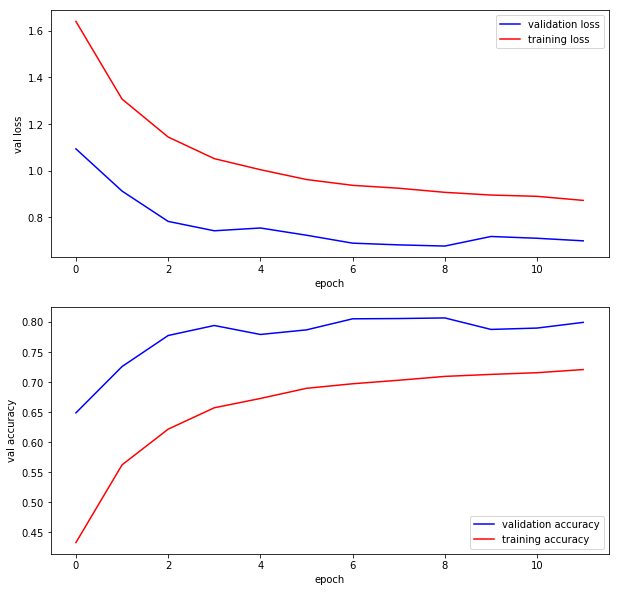

In [23]:
plot_models(history_cnn.history)

In [24]:
! ls -lh checkpoints_best_only_cnn

total 1.3M
-rw-r--r-- 1 jovyan users   77 Mar  6 21:26 checkpoint
-rw-r--r-- 1 jovyan users 1.3M Mar  6 21:26 checkpoint.data-00000-of-00001
-rw-r--r-- 1 jovyan users 2.9K Mar  6 21:26 checkpoint.index


## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [25]:
def get_best_model_mlp(model):
    model = get_mlp_model(x_train_gray[0].shape)
    model.load_weights("checkpoints_best_only_mlp/checkpoint")
    model.compile(optimizer='ada,',
          loss='categorical_crossentropy',
          metrics=['accuracy']
    )
   

    return model

    
def get_best_model_cnn(model):
    model = get_cnn_model(x_train_gray[0].shape, 0.3)
    model.load_weights("/content/checkpoints_best_only_cnn/checkpoint")
    model.compile(optimizer='adam',
          loss='categorical_crossentropy',
          metrics=['accuracy']
    )


    return model
  
def random_img_from_model(model):
    num_test_images = x_test_gray.shape[0]

    random_inx = np.random.choice(num_test_images, 5)
    random_test_images = x_test_gray[random_inx, ...]
    random_test_labels = y_test[random_inx, ...]

    predictions = model.predict(random_test_images)

    fig, axes = plt.subplots(5, 2, figsize=(16, 12))
    fig.subplots_adjust(hspace=0.4, wspace=-0.2)

    for i, (prediction, image, label) in enumerate(zip(predictions, 
                                                       random_test_images, 
                                                       random_test_labels)):
        axes[i, 0].imshow(np.squeeze(image))
        axes[i, 0].get_xaxis().set_visible(False)
        axes[i, 0].get_yaxis().set_visible(False)
        axes[i, 0].text(10., -1.5, f'label: {np.argmax(random_test_labels[i])}')
        axes[i, 1].bar(np.arange(len(prediction)), prediction)
        axes[i, 1].set_xticks(np.arange(len(prediction)))
        axes[i, 1].set_title(f"Categorical distribution. Model prediction: 
                             {np.argmax(predictions[i])}")



    return model


In [26]:
print("MLP Result: ")
get_test_results(model_mlp, x_test_gray, y_test)

print('\n')
print('CNN Result: ')
get_test_results(model_cnn, x_test_gray, y_test)

MLP Result: 
Test accuracy is 0.7609865069389343
Test loss is 0.7949237119917058


CNN Result: 
Test accuracy is 0.7798863053321838
Test loss is 0.7619658905300687


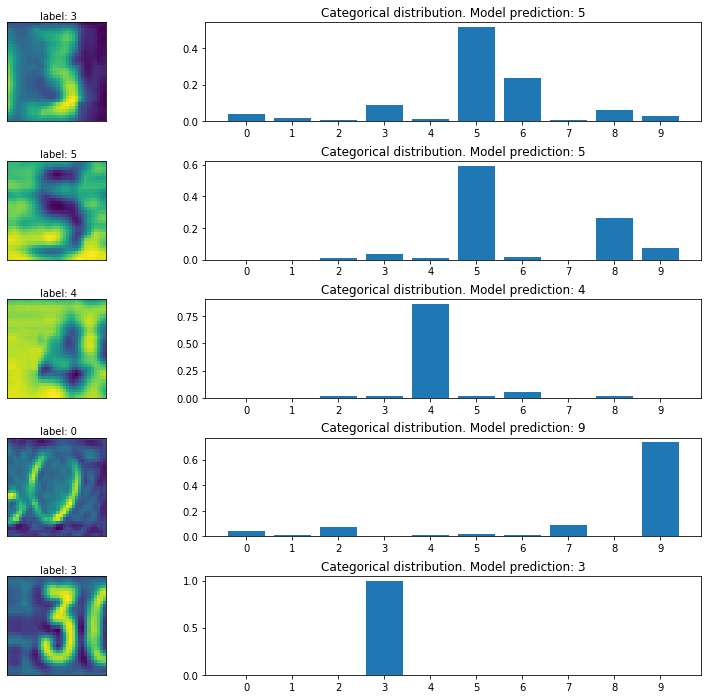

In [27]:
random_img_from_model(model_mlp)

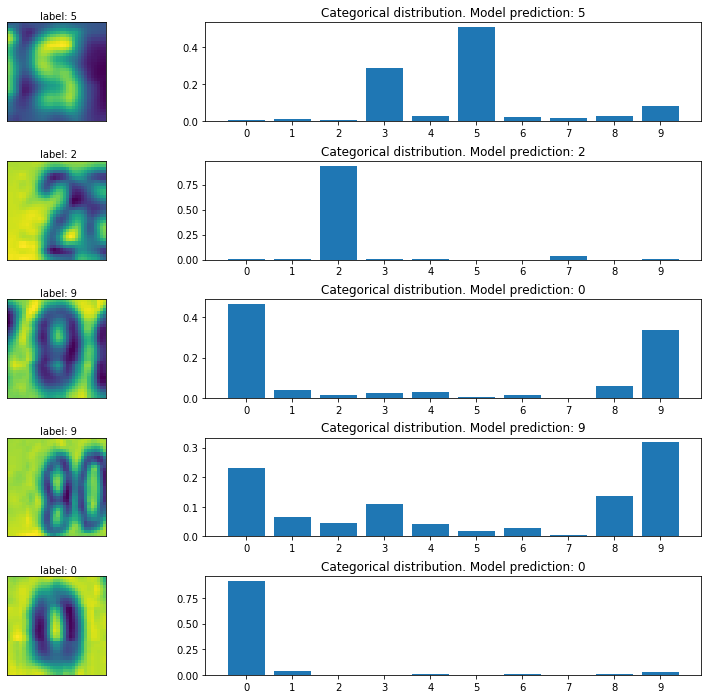

In [28]:
random_img_from_model(model_cnn)